In [1]:
# importing all necessary library

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram

filename = '1M.csv'
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]

# extracting the value of G-K filter
g_k_1m = df['phot_g_mean_mag'] - df['ks_m']

In [3]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query1 = """SELECT TOP {}""".format(query_size) + """
        g.ra, g.dec, g.parallax, g.parallax_error, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid))
        """

    job2 = Gaia.launch_job(query1)
    result1 = job2.get_results()

    return result1

In [4]:
# Extrtacting list of stars around Herbig Ae/Be Star
herbig1 = get_gaia_result(1000, 193.3217131, -77.1196488, 12./60.)
herbig1 = herbig1[herbig1['parallax_error'] < 0.3]

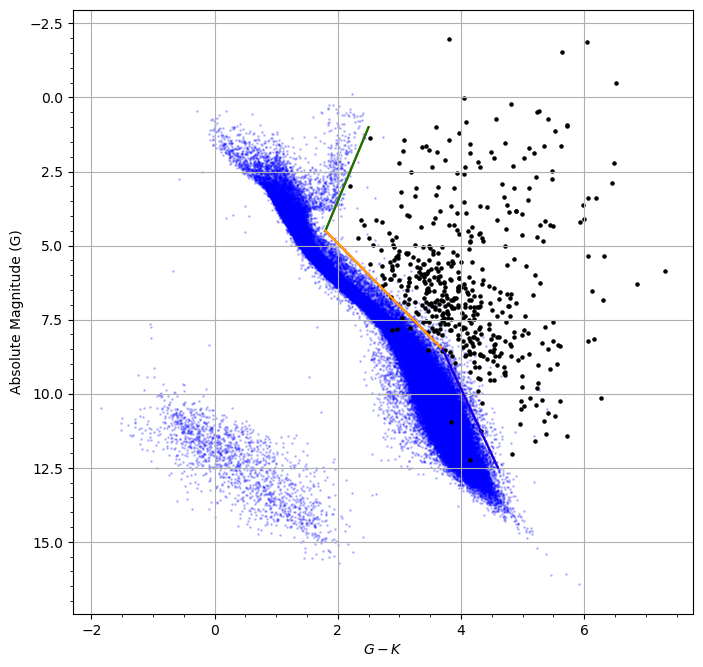

In [5]:
%matplotlib inline

her_gk = herbig1['phot_g_mean_mag'] - herbig1['ks_m']
her_mg = herbig1['mv']

# Defining the equation of straight line for the boundries
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# plotting the lines using just two points 
ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'green')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'blue')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')
#ax.scatter(g_k3, mg3, marker='+', color = 'red', s = 5, label = 'Random Star')
#ax3.colorbar(aspect = 50)
ax.minorticks_on()
ax.grid(True)
# ax3.set_xlim(min(df.bp_rp), max(df.bp_rp))
ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
plt.show()


## Counting Function 

In [6]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        if 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        if 8.5 < her_mg[i] and her_mg[i] < 12.5:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1


    return count_red

In [7]:
n_stars = counting_fun(her_mg, her_gk)

print("total number of stars = {}".format(n_stars))

print(len(her_gk), len(her_mg))
# for i in range(len(her_mg)):
#     print(her_mg[i], her_gk[i])

Prob_red_her = n_stars/len(her_mg)
print(Prob_red_her)

total number of stars = 460
470 470
0.9787234042553191


In [8]:
rand_star = get_gaia_result(1000, 72.77801742, 0.546141291, 12./60.)
rand_star = rand_star[rand_star['parallax_error']< 0.3]

In [9]:
rand_gk = rand_star['phot_g_mean_mag'] - rand_star['ks_m']
rand_mg = rand_star['mv']

In [10]:
rand_count = counting_fun(rand_mg, rand_gk)
rand_count

33

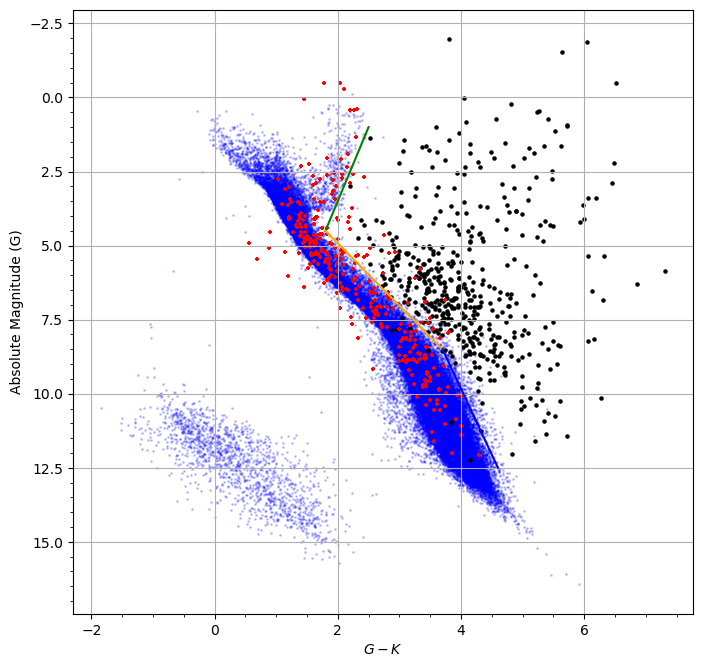

In [11]:
%matplotlib inline

her_gk = herbig1['phot_g_mean_mag'] - herbig1['ks_m']
her_mg = herbig1['mv']
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# x_values1 = np.linspace(1.8, 2.5, 50)
# x_values2 = np.linspace(1.8, 3.7, 100)
# x_values3 = np.linspace(3.7, 12.5, 100)


y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)")
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')
ax.plot(equation1(y_values1), y_values1,  color = 'green')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')

ax.plot(equation3(y_values3), y_values3, color = 'blue')

ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')

ax.scatter(rand_gk, rand_mg, marker='+', color = 'red', s = 5, label = 'Random Star')

ax.minorticks_on()
ax.grid(True)
# ax3.set_xlim(min(df.bp_rp), max(df.bp_rp))
ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
plt.show()


## Importing list of 20 Herbig Ae/Be and Random Stars

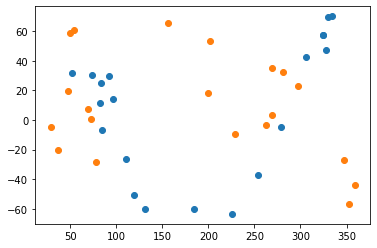

In [12]:
# importing 20 Herbig Stars

herbig_list = pd.read_csv("Herbig20.csv")
herbig_20 = herbig_list[["Name", "RAICRS", "DEICRS"]].copy()

# taking 20 random stars from Gaia Database
randstar_20 = df[["ra", "dec"]].head(20)
randstar_20 = randstar_20.reset_index(drop=True)
plt.scatter(herbig_20.RAICRS, herbig_20.DEICRS)
plt.scatter(randstar_20.ra, randstar_20.dec)

plt.show()


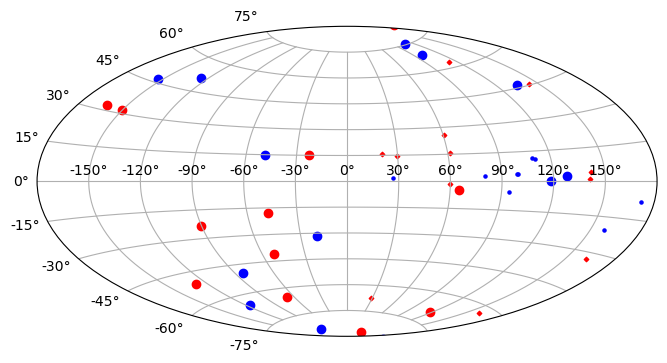

In [13]:
%matplotlib inline
rand_cordi = SkyCoord(randstar_20['ra'], randstar_20['dec'], unit = (u.deg, u.deg))

rand_cordi_gal = rand_cordi.transform_to('galactic')



her_cordi = SkyCoord(herbig_20['RAICRS'], herbig_20['DEICRS'], unit = (u.deg, u.deg))
her_cordi_gal = her_cordi.transform_to("galactic")


fig = plt.figure(dpi = 100, figsize = [8, 5])
ax = fig.add_subplot(1, 1, 1 , projection = 'aitoff')
ax.scatter(herbig_20.RAICRS, herbig_20.DEICRS, color = 'blue')
ax.scatter(randstar_20.ra, randstar_20.dec, color = 'red')
ax.scatter(rand_cordi_gal.l.radian, rand_cordi_gal.b.radian, color = 'red', s = 5, marker = 'D')
ax.scatter(her_cordi_gal.l.radian, her_cordi_gal.b.radian, s = 5, color = 'blue')
ax.grid()
plt.show()

In [14]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star


    for i in range(len(herbig_20.RAICRS)):

        herbig_star = get_gaia_result(1000, herbig_20.loc[i][1], herbig_20.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        rand_star = get_gaia_result(1000, randstar_20.loc[i][0], randstar_20.loc[i][1], radius)
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

        y_values1 = np.linspace(1, 4.5, 50)
        y_values2 = np.linspace(4.5, 8.5, 100)
        y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe')

        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'green')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'green')



        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)
        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)

        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand
    
    


In [15]:
all_list = list_red_object(3.0/60.0)

In [16]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]

In [17]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Probabaility of red object")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herbig_20.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}".format(num_red_star_her[i]/num_tot_star_her[i]))

print("\n")
print(" Average number of red objects around a Herbig Star = ", np.average(num_red_star_her))


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Probability of red object")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}".format(num_red_star_rand[i]/num_tot_star_rand[i]))

print("\n")

print(" Average number of red objects around a Random Star = ", np.average(num_red_star_rand))



-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Probabaility of red object
-----------------------------------------------------------------------------------------
 AB Aur    		 	  12	 	 13	 	 	0.9231
 AK Sco    		 	 111	 	116	 	 	0.9569
 AS 310    		 	  19	 	 21	 	 	0.9048
 AS 470    		 	  55	 	 63	 	 	0.8730
 AS 477    		 	  34	 	 50	 	 	0.6800
 BD+30 549 		 	   6	 	  7	 	 	0.8571
 BD+41 3731		 	   9	 	 16	 	 	0.5625
 BF Ori    		 	   3	 	  5	 	 	0.6000
 BH Cep    		 	  33	 	 55	 	 	0.6000
 BO Cep    		 	  30	 	 52	 	 	0.5769
 CO Ori    		 	  17	 	 30	 	 	0.5667
 CPM 25    		 	  28	 	 67	 	 	0.4179
 CQ Tau    		 	  26	 	 41	 	 	0.6341
 DG Cir    		 	  41	 	 46	 	 	0.8913
 GSC 1876-0892		 	  18	 	 50	 	 	0.3600
 GSC 3975-0579		 	  67	 	 76	 	 	0.8816
 GSC 6546-3156		 	  54	 	 76	 	 	0.7105
 GSC 8143-1225		 	  26	 	 59	 	 	0.4407
 GSC 8581-2002		 	  39	 	 54	 	 	0.7222
 GSC 8645-14

In [18]:
search_radius = np.arange(2, 10.1, 2.0)/60
avg_star_her = []
avg_star_rand = []

for i in range(len(search_radius)):

    all_list = list_red_object(search_radius[i])

    num_red_star_her = all_list[0]
    num_red_star_rand = all_list[2]
    

    avg_her = np.average(num_red_star_her)
    avg_rand = np.average(num_red_star_rand)
    avg_star_her.append(avg_her)
    avg_star_rand.append(avg_rand)


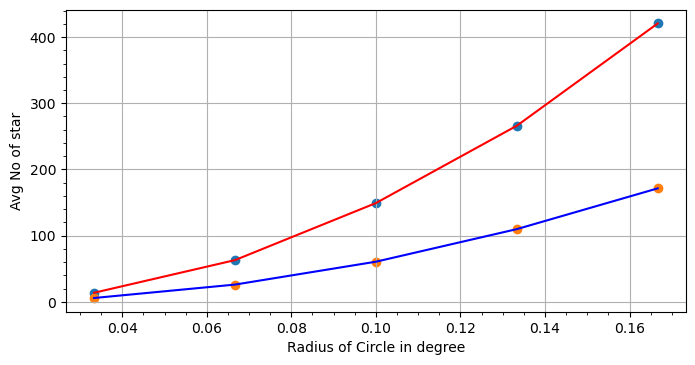

[13.85, 63.15, 149.3, 266.05, 420.5] [5.95, 26.2, 60.75, 109.95, 171.5]


In [19]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (8, 4), dpi = 100)
ax.plot(search_radius, avg_star_her, c = 'red')
ax.plot(search_radius, avg_star_rand, c = 'blue')
ax.scatter(search_radius, avg_star_her)
ax.scatter(search_radius, avg_star_rand)
ax.minorticks_on()
ax.grid()

ax.set_xlabel("Radius of Circle in degree")
ax.set_ylabel("Avg No of star")

plt.show()

print(avg_star_her, avg_star_rand)

In [20]:
randstar_20 = randstar_20.reset_index(drop=True)
rand_cordi = SkyCoord(randstar_20['ra'], randstar_20['dec'], unit = (u.deg, u.deg))

rand_cordi_gal = rand_cordi.transform_to('galactic')



her_cordi = SkyCoord(herbig_20['RAICRS'], herbig_20['DEICRS'], unit = (u.deg, u.deg))
her_cordi_gal = her_cordi.transform_to("galactic")

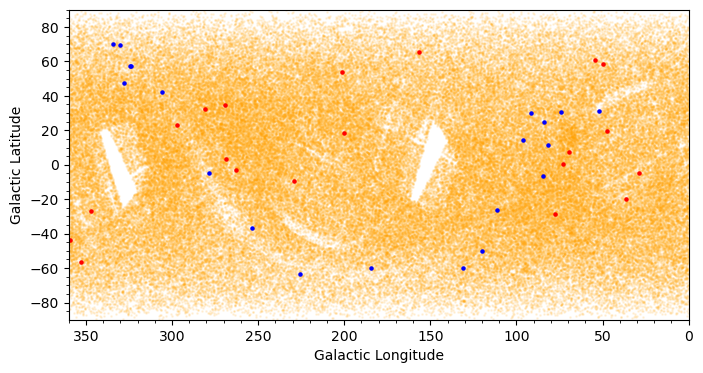

In [21]:

fig = plt.figure(dpi = 100, figsize=[8, 5])
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.scatter(df.ra, df.dec, s=1, color='orange', alpha=0.1)
ax.scatter(rand_cordi.ra, rand_cordi.dec, s = 5, color = 'red')
ax.scatter(her_cordi.ra, her_cordi.dec, s = 5, color = 'blue')
ax.set_xlim(360., 0.)
ax.set_ylim(-90., 90.)
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.minorticks_on()
plt.show()

In [22]:

one = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))

In [34]:
one

<SkyCoord (ICRS): (ra, dec) in deg
    [( 72.77801742,   0.54614129), ( 47.43349471,  19.41150788),
     ( 28.67107997,  -4.86380406), ..., (  4.61266774,  44.02472958),
     (176.93760359,   0.79928984), (282.45869194, -23.83707047)]>

In [24]:
one_gal = one.transform_to('galactic')

In [25]:
one_gal.l

<Longitude [197.61260321, 162.4044564 , 159.82469539, ..., 116.69017149,
            270.15662005,  11.30761796] deg>

In [38]:
# this for alll stars
l_rad = one_gal.l.radian
l_rad[l_rad > np.pi] -= 2. * np.pi
b_rad = one_gal.b.radian

# this sis for Herbig star
l_her = her_cordi_gal.l.radian
l_her[l_her>np.pi] -= 2.0*np.pi
b_her = her_cordi_gal.b.radian

# for 20 random star
l_random = rand_cordi_gal.l.radian
l_random[l_random>np.pi] -= 2.0 * np.pi
b_random = rand_cordi_gal.b.radian



In [44]:
%matplotlib qt


fig = plt.figure(figsize = [10, 6], dpi = 100)
ax = fig.add_subplot(1,1,1, projection='aitoff')
ax.scatter(l_rad, b_rad, s=1, color='orange', alpha=0.1)
ax.scatter(l_random, b_random, color = 'red', s = 10, marker = 'D', label = 'Random')
ax.scatter(l_her, b_her, s = 19, color = 'blue', label = 'Herbig', marker = 'x')
ax.legend()
ax.grid()
plt.show()

-14

In [29]:
len(rand_cordi_gal.l)

20